# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='notebook_ims/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='notebook_ims/denoising.png' width=60%/>

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

100.1%Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw
113.5%Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw
100.4%Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
180.4%Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

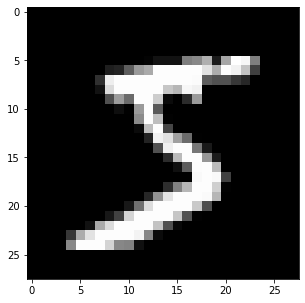

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='notebook_ims/simple_autoencoder.png' width=50% />


#### TODO: Build the graph for the autoencoder in the cell below. 
> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. 
> The encoder and decoder will be made of two linear layers, each.
> The depth dimensions should change as follows: 784 inputs > **encoding_dim** > 784 outputs.
> All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

**The compressed representation should be a vector with dimension `encoding_dim=32`.**

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.compressed = nn.Linear(784, encoding_dim)
                
        ## decoder ##
        self.output = nn.Linear(encoding_dim, 784)
        

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        # x = x.view(-1, 28 * 28)
        x = F.relu(self.compressed(x))
        x = F.sigmoid(self.output(x))

        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (compressed): Linear(in_features=784, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=784, bias=True)
)


In [16]:
model.parameters[0]

TypeError: 'method' object is not subscriptable

---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [21]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.669982
Epoch: 2 	Training Loss: 0.364643
Epoch: 3 	Training Loss: 0.315630
Epoch: 4 	Training Loss: 0.299545
Epoch: 5 	Training Loss: 0.295378
Epoch: 6 	Training Loss: 0.293249
Epoch: 7 	Training Loss: 0.291863
Epoch: 8 	Training Loss: 0.290722
Epoch: 9 	Training Loss: 0.289773
Epoch: 10 	Training Loss: 0.289108
Epoch: 11 	Training Loss: 0.288522
Epoch: 12 	Training Loss: 0.287986
Epoch: 13 	Training Loss: 0.287463
Epoch: 14 	Training Loss: 0.286986
Epoch: 15 	Training Loss: 0.286524
Epoch: 16 	Training Loss: 0.286037
Epoch: 17 	Training Loss: 0.285631
Epoch: 18 	Training Loss: 0.285263
Epoch: 19 	Training Loss: 0.284909
Epoch: 20 	Training Loss: 0.284552


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

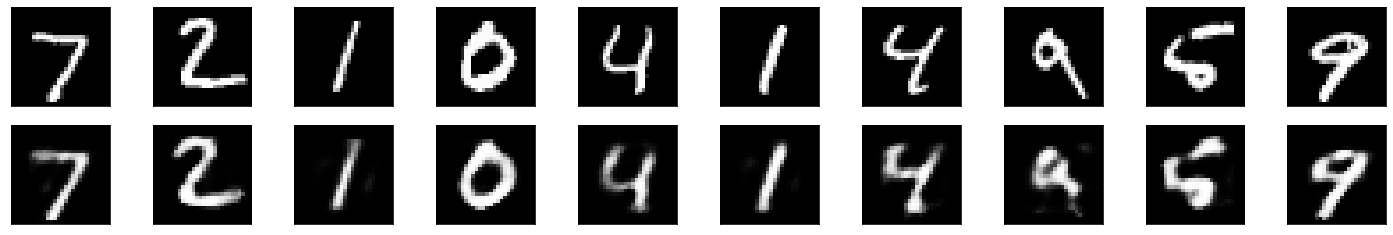

In [23]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.